In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""Train forecasting model.

Author:
    Erik Johannes Husom

Created:
    2024-03-21

"""
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from config import config

2024-06-05 11:27:46.282827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 11:27:47.845011: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Function to preprocess the data
def preprocess_data(df, target_column, scale_features=False, unique_val_threshold=7):

    # Drop unrelated or irrelevant variables
    columns_to_drop = [
            "energy_consumption_monitoring",
            # "total_duration",
            # "response_duration",
            #"response_token_length",
            "prompt_duration",
            "index",
            "load_duration",
            "Unnamed: 0",
            "created_at",
            "response",
            # "prompt",
            # "text_standard",
    ]
    df = df.drop(columns=columns_to_drop)

    # df = df[[target_column, "prompt", "type"]]

    # Drop target column and rows with NA in target column
    df = df.dropna(subset=[target_column])
    y = df[target_column]
    X = df.drop(columns=[target_column])
    X = X[[
        # 'prompt', 
        # 'type',
        # "model_name",
        # "total_duration",
        # "load_duration",
        # "prompt_token_length",
        # "prompt_duration",
        "response_token_length",
        # "response_duration",
        # "response",
        # "energy_consumption_monitoring",
        # "energy_consumption_llm",
        # "word_count",
        # "sentence_count",
        # "avg_word_length",
        # "word_diversity",
        # "unique_word_count",
        # "avg_sentence_length",
        # "punctuation_count",
        # "stop_word_count",
        # "long_word_count",
        # "named_entity_count",
        # "noun_count",
        # "verb_count",
        # "adj_count",
        # "adverb_count",
        # "pronoun_count",
        # "prop_adverbs",
        # "prop_pronouns",
        # "sentiment_polarity",
        # "sentiment_subjectivity",
        # "flesch_reading_ease",
        # "flesch_kincaid_grade",
        # "gunning_fog",
        # "smog_index",
        # "automated_readability_index",
        # "coleman_liau_index",
        # "linsear_write_formula",
        # "dale_chall_readability_score",
        # "text_standard",
        # "spache_readability",
        # "mcalpine_eflaw",
        # "reading_time",
        # "fernandez_huerta",
        # "szigriszt_pazos",
        # "gutierrez_polini",
        # "crawford",
        # "osman",
        # "gulpease_index",
        # "wiener_sachtextformel",
        # "syllable_count",
        # "lexicon_count",
        # "char_count",
        # "letter_count",
        # "polysyllabcount",
        # "monosyllabcount",
        # "question_marks",
        # "exclamation_marks",
        # "sentence_embedding_variance",
        # "personal_pronouns",
        # "named_entities",
        # "adjectives",
        # "adverbs",
        # "length_x_complexity",
        # "questions_about_entities",
        # "desc_complexity_ratio",
        # "word_count_squared",
        # "avg_sentence_length_cubed",
        # "lexical_diversity",
    ]]

    # Identify numeric, text, and categorical columns
    numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    potential_categorical = X.select_dtypes(include=['object', 'category']).columns.tolist()
    text_columns = [col for col in potential_categorical if X[col].nunique() > unique_val_threshold]
    categorical_columns = list(set(potential_categorical) - set(text_columns))

    # X = X.drop(columns=text_columns)

    # Define transformers
    transformers = []
    if scale_features:
        transformers.append(('num', StandardScaler(), numeric_columns))
    if text_columns:
        transformers.append(('text', TfidfVectorizer(), "prompt"))
    if categorical_columns:
        transformers.append(('cat', OneHotEncoder(), categorical_columns))

    # Column Transformer
    preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Applying the ColumnTransformer
    # Note: This step now includes fitting the transformer, so it should be applied here rather than in the model pipeline.
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    return X_train, X_test, y_train, y_test

def neural_network(input_shape=57):
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_shape,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer=Adam(), loss='mse')

    return model

# Function to select the machine learning model
def select_model(model_name):
    models = {
        "random_forest": RandomForestRegressor(),
        "decision_tree": DecisionTreeRegressor(),
        "gradient_boosting": GradientBoostingRegressor(),
        "xgboost": xgb.XGBRegressor(),
        "svm": SVR(),
        "linear_regression": LinearRegression(),
        "neural_network": neural_network(),
    }
    return models.get(model_name, LinearRegression())  # Default to Linear Regression

# Function to train the model and evaluate it
def train_and_evaluate(file_name, model_name, X_train, X_test, y_train, y_test):
    model = select_model(model_name)

    if model_name == "neural_network":
        model.fit(X_train, y_train, epochs=1000)
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # print(f"Model: {model_name}")
    # print(f"MSE: {mse}")
    # print(f"MAE: {mae}")
    # print(f"R^2: {r2}")
    print(f"{file_name[:file_name.index('.csv')]} & {mse} & {mae} & {r2}")

    # if r2 > 0.2:
    plot_true_vs_predicted(y_test, y_pred, model_name, file_name)

    return model, mse, mae, r2

def plot_true_vs_predicted(y_true, y_pred, model_name, file_name):
    plt.figure(figsize=(5, 3))
    plt.scatter(y_true, y_pred, alpha=0.5, color='blue', label='Predicted')
    plt.plot(y_true, y_true, color='red', label='True')  # Line for perfect predictions
    plt.title(f'True vs. Predicted Energy Consumption - {file_name}_{model_name}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f"{config.PLOTS_DIR_PATH}/{file_name}_{model_name}_onlyprompt.pdf")
    plt.savefig(f"{config.PLOTS_DIR_PATH}/{file_name}_{model_name}.pdf")
    plt.show()

def new_train(df):
    # Preparing the dataset
    X = df[[
        'prompt', 
        'type',
        # "model_name",
        # "total_duration",
        # "load_duration",
        "prompt_token_length",
        # "prompt_duration",
        # "response_token_length",
        # "response_duration",
        # "response",
        # "energy_consumption_monitoring",
        # "energy_consumption_llm",
        "word_count",
        "sentence_count",
        "avg_word_length",
        "word_diversity",
        "unique_word_count",
        "avg_sentence_length",
        "punctuation_count",
        "stop_word_count",
        "long_word_count",
        "named_entity_count",
        "noun_count",
        "verb_count",
        "adj_count",
        "adverb_count",
        "pronoun_count",
        "prop_adverbs",
        "prop_pronouns",
        "sentiment_polarity",
        "sentiment_subjectivity",
        "flesch_reading_ease",
        "flesch_kincaid_grade",
        "gunning_fog",
        "smog_index",
        "automated_readability_index",
        "coleman_liau_index",
        "linsear_write_formula",
        "dale_chall_readability_score",
        "text_standard",
        "spache_readability",
        "mcalpine_eflaw",
        "reading_time",
        "fernandez_huerta",
        "szigriszt_pazos",
        "gutierrez_polini",
        "crawford",
        "osman",
        "gulpease_index",
        "wiener_sachtextformel",
        "syllable_count",
        "lexicon_count",
        "char_count",
        "letter_count",
        "polysyllabcount",
        "monosyllabcount",
        "question_marks",
        "exclamation_marks",
        "sentence_embedding_variance",
        "personal_pronouns",
        "named_entities",
        "adjectives",
        "adverbs",
        "length_x_complexity",
        "questions_about_entities",
        "desc_complexity_ratio",
        "word_count_squared",
        "avg_sentence_length_cubed",
        "lexical_diversity",
    ]]
    y = df['energy_consumption_llm']

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining the transformation for text and categorical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('text', TfidfVectorizer(), 'prompt'),
            ('cat', OneHotEncoder(), ['type'])
        ])

    # Creating a modeling pipeline
    model = make_pipeline(preprocessor, RandomForestRegressor(n_estimators=100))
    # model = make_pipeline(preprocessor, LinearRegression())

    # Training the model
    model.fit(X_train, y_train)

    print(X_train)
    print(y_train)

    # Predicting and evaluating
    y_pred = model.predict(X_test)
    print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
    print("R2: ", r2_score(y_test, y_pred))

    plot_true_vs_predicted(y_test, y_pred, "RandomForestRegressor")



alpaca_llama3_70b_server.csv
../data/main_results/alpaca_llama3_70b_server.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_llama3_70b_server & 2.2534631178860613e-06 & 0.0011257491079801798 & 0.3596493753532768


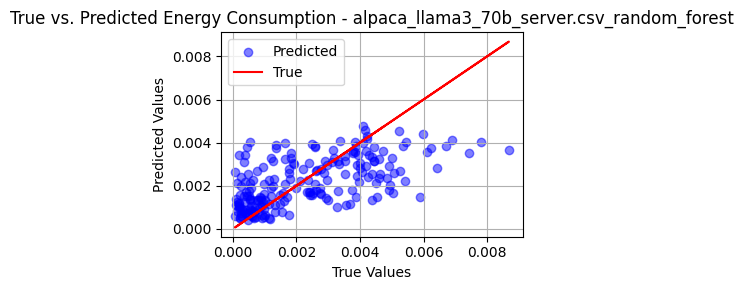

/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_llama3_70b_server & 4.481024902294983e-06 & 0.0015284708382278765 & -0.27334105114348595


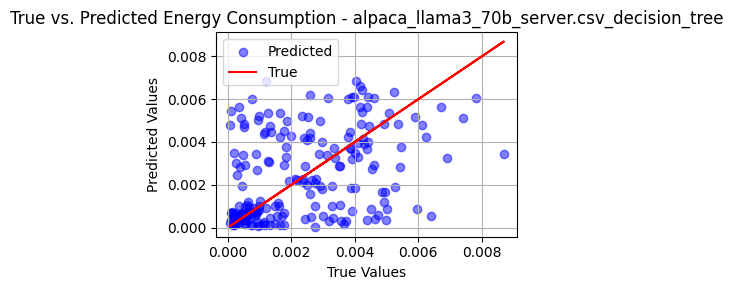

/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_llama3_70b_server & 1.9749055336574322e-06 & 0.0010688128648036076 & 0.43880510754392166


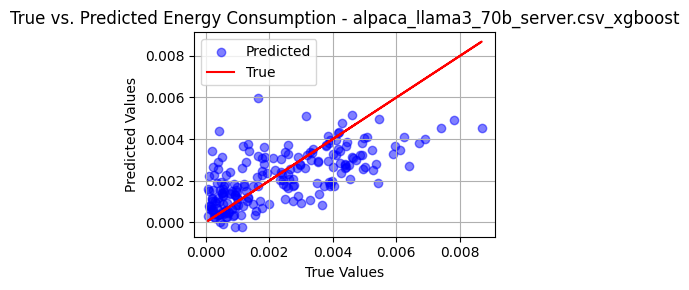

codefeedback_codellama_7b_workstation.csv
../data/main_results/codefeedback_codellama_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_workstation & 8.89737440261645e-08 & 0.00010338094478177835 & -0.8027507990022431


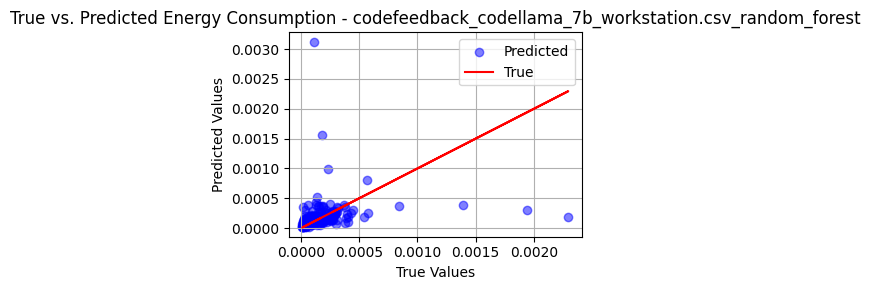

/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_workstation & 2.9824722528494927e-06 & 0.00020307917483079456 & -59.42967277228809


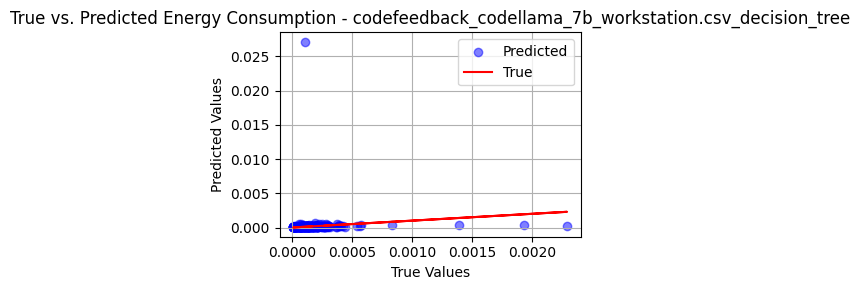

/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_workstation & 4.446126010365957e-08 & 8.809485646544441e-05 & 0.09914353887425043


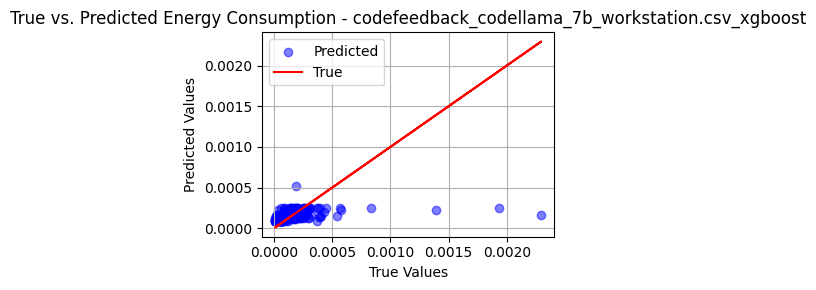

alpaca_gemma_2b_laptop1.csv
../data/main_results/alpaca_gemma_2b_laptop1.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [17]:
import os 
directory = "../data/main_results"
for filename in os.listdir(directory):
    if not filename.startswith("."):
        print(filename)
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            print(f)

            df = pd.read_csv(f)  # Replace with your dataset path
            df = df.dropna(axis=0) # drop rows with nan
            # df = pd.read_csv(config.MAIN_DATASET_PATH)  # Replace with your dataset path
            X_train, X_test, y_train, y_test = preprocess_data(df, "energy_consumption_llm", scale_features=True)

            # Easily switch between models by changing the model name
            # model_names = ["random_forest", "decision_tree", "gradient_boosting", "xgboost", "svm", "linear_regression"]#, "neural_network"]
            model_names = ["random_forest",  "decision_tree", "xgboost" ]#, "neural_network"]
            # model_names = ["linear_regression"]
            for model_name in model_names:
                train_and_evaluate(filename, model_name, X_train, X_test, y_train, y_test)

alpaca_llama3_70b_server.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-05 11:30:21.589997: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 11:30:21.599001: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and set

alpaca_llama3_70b_server & 2.3953091751556076e-07 & 0.0002707561571809186 & 0.9319341987734954


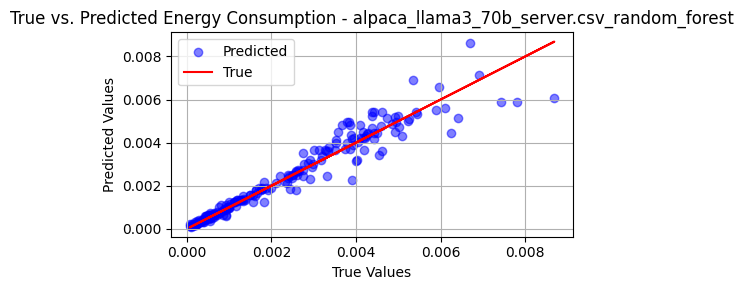

codefeedback_codellama_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_workstation & 2.0651363613658715e-08 & 1.5775149367891107e-05 & 0.8968861236414577


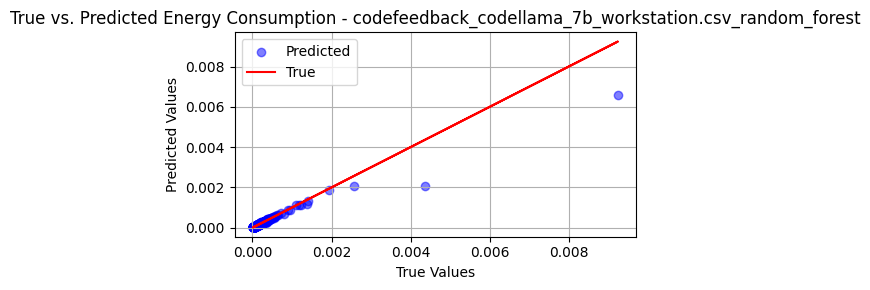

alpaca_gemma_2b_laptop1.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_laptop1 & 5.006128348323588e-09 & 3.355042550175379e-05 & 0.7424480930046629


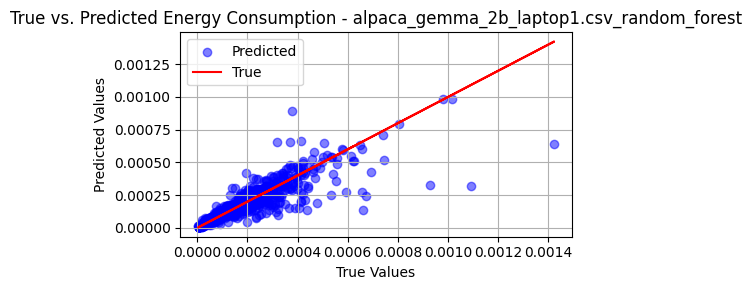

alpaca_gemma_2b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_workstation & 7.231017617578721e-12 & 1.7926206932570266e-06 & 0.9923197298410715


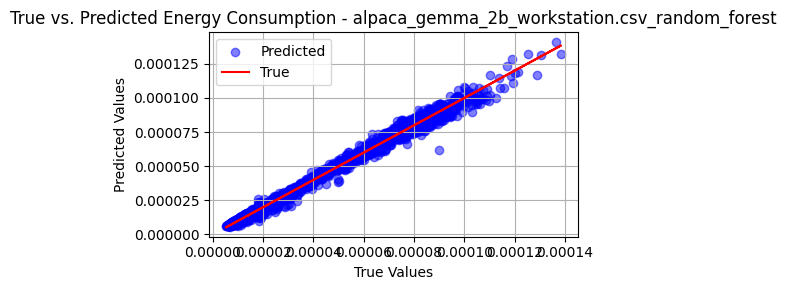

alpaca_gemma_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_7b_laptop2 & 3.741692286343274e-12 & 1.2437417159740274e-06 & 0.9994781492982201


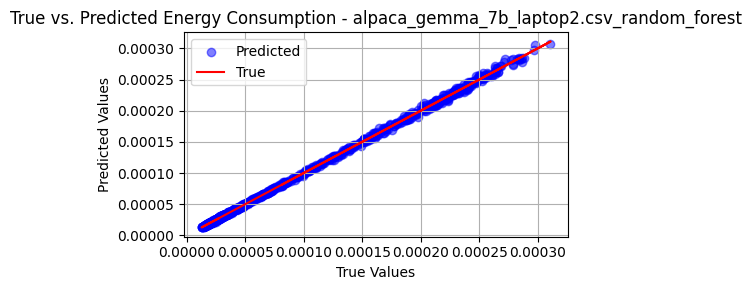

codefeedback_gemma_2b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_2b_laptop2 & 4.5192901649468765e-12 & 1.2964666699360943e-06 & 0.9968789926305452


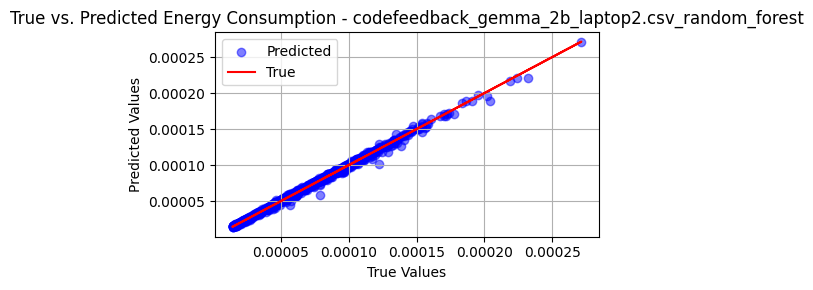

codefeedback_codellama_7b_laptop1.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_laptop1 & 5.111437929038748e-09 & 3.375282347106629e-05 & 0.7370301968879658


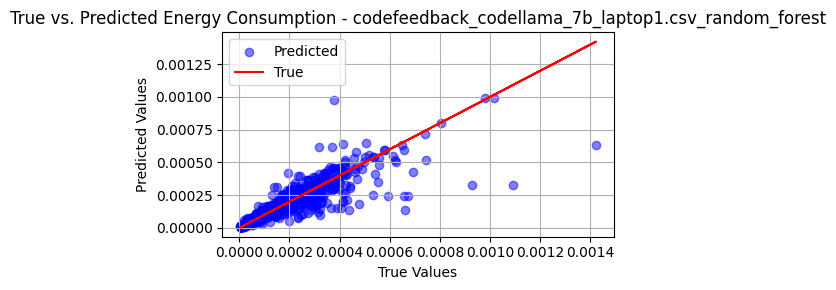

codefeedback_codellama_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_7b_laptop2 & 1.0594242595181973e-10 & 5.517659227162045e-06 & 0.9955205700068345


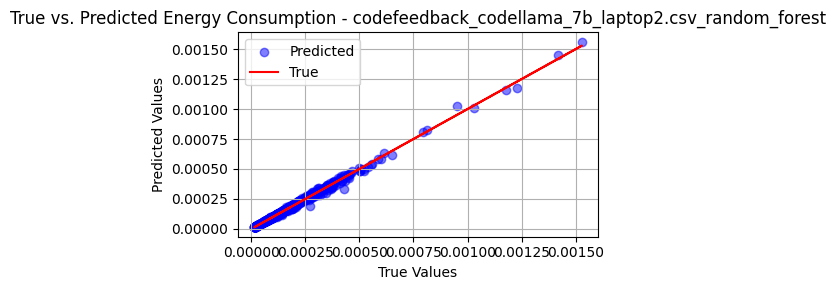

codefeedback_gemma_2b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_2b_workstation & 6.165515278985785e-12 & 1.3337850730634015e-06 & 0.9959402745254213


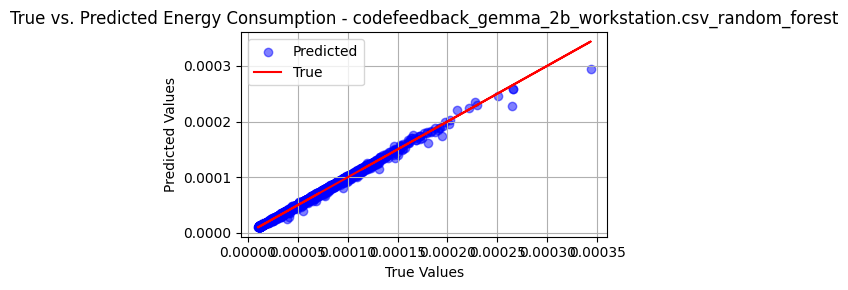

alpaca_llama3_8b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_llama3_8b_laptop2 & 2.3803594117397736e-11 & 1.654622428208519e-06 & 0.9976523732359273


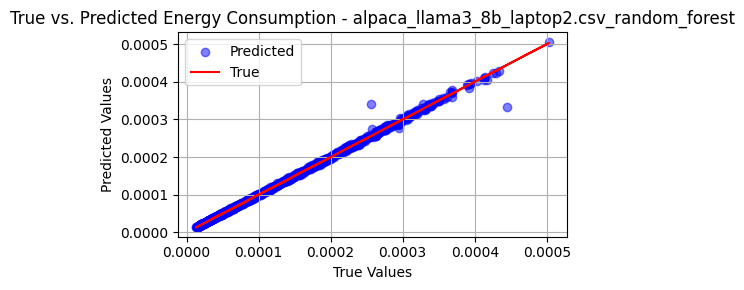

codefeedback_gemma_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_7b_workstation & 1.2061608389870331e-10 & 5.99268209347896e-06 & 0.9786574295877373


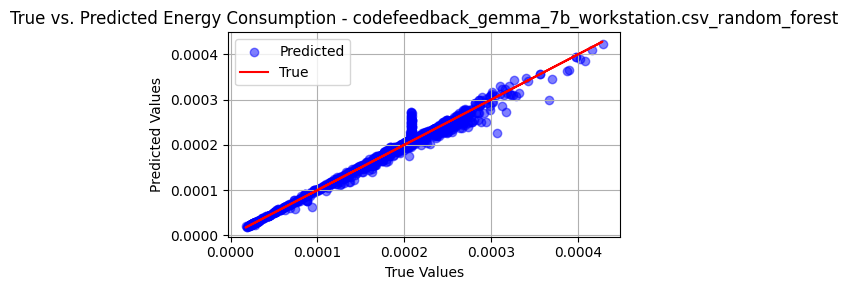

alpaca_gemma_7b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_7b_workstation & 6.943313377521566e-11 & 5.458843450383768e-06 & 0.9915885848345096


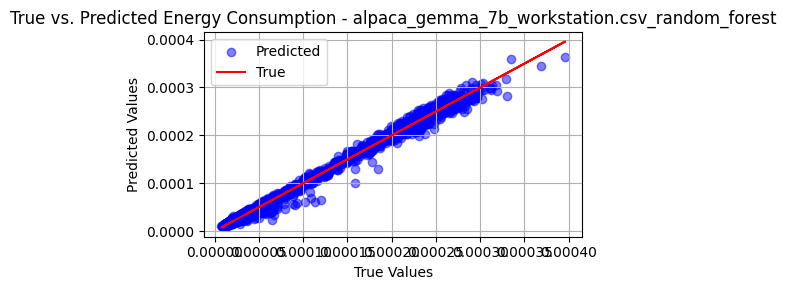

codefeedback_gemma_7b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_gemma_7b_laptop2 & 8.917280243321264e-11 & 4.954710951478598e-06 & 0.9886008132603299


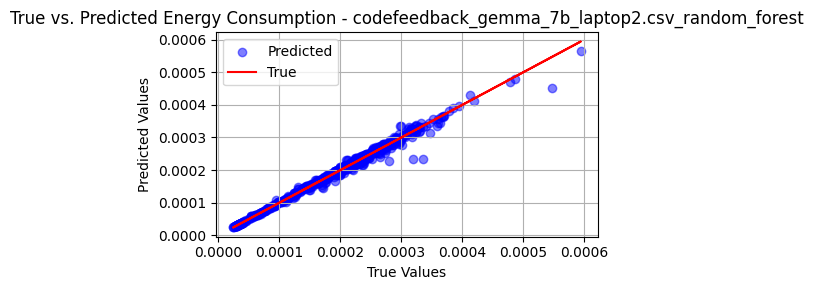

codefeedback_codellama_70b_workstation.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


codefeedback_codellama_70b_workstation & 1.0015893849577089e-07 & 0.0001895473502991269 & 0.9938800060068846


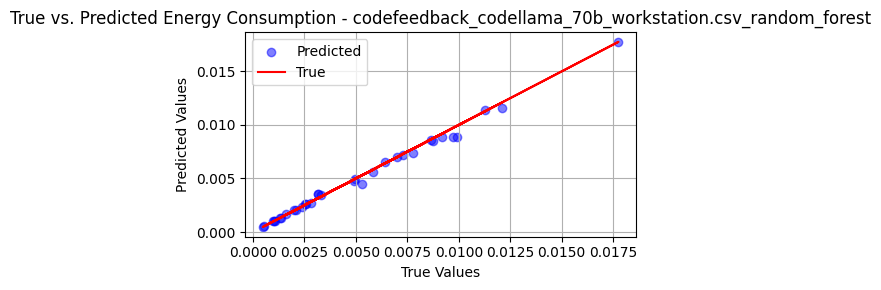

alpaca_gemma_2b_laptop2.csv


/home/erikhu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


alpaca_gemma_2b_laptop2 & 1.3421220697602958e-10 & 8.900831377411652e-07 & 0.9132570925308382


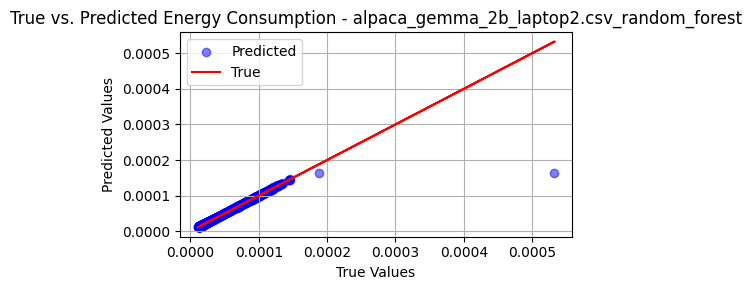

In [4]:
import os 
directory = "../data/main_results"

results = {}

for filename in os.listdir(directory):
    if not filename.startswith("."):
        print(filename)
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            # print(f)

            df = pd.read_csv(f)  # Replace with your dataset path
            df = df.dropna(axis=0) # drop rows with nan
            # df = pd.read_csv(config.MAIN_DATASET_PATH)  # Replace with your dataset path
            X_train, X_test, y_train, y_test = preprocess_data(df, "energy_consumption_llm", scale_features=True)

            # Easily switch between models by changing the model name
            # model_names = ["random_forest", "decision_tree", "gradient_boosting", "xgboost", "svm", "linear_regression"]#, "neural_network"]
            model_names = ["random_forest"]#, "neural_network"]
            # model_names = ["linear_regression"]
            for model_name in model_names:
                model, mse, mae, r2 = train_and_evaluate(filename, model_name, X_train, X_test, y_train, y_test)
                results[filename] = r2

In [12]:
results_df = pd.DataFrame(list(results.items()), columns=["dataset", "R2"])
#results_df = results_df.sort_values(by="R2", ascending=False)
results_df

,dataset,R2
0,alpaca_llama3_70b_server.csv,0.931934
1,codefeedback_codellama_7b_workstation.csv,0.896886
2,alpaca_gemma_2b_laptop1.csv,0.742448
3,alpaca_gemma_2b_workstation.csv,0.992320
4,alpaca_gemma_7b_laptop2.csv,0.999478
5,codefeedback_gemma_2b_laptop2.csv,0.996879
6,codefeedback_codellama_7b_laptop1.csv,0.737030
7,codefeedback_codellama_7b_laptop2.csv,0.995521
8,codefeedback_gemma_2b_workstation.csv,0.995940
9,alpaca_llama3_8b_laptop2.csv,0.997652


In [13]:
results_df.to_csv("r2_results.csv")